In [1]:
from re import compile

from numpy import arange
from pandas import read_csv, DataFrame
from scipy.stats import ttest_rel
from seaborn import set_style, color_palette, lineplot, FacetGrid, histplot, set_theme

In [2]:
def target_f1(name: str) -> float:
    parts = name.split(" + ")
    for part in parts:
        if part.startswith("randomize"):
            match = compile(r"randomize\(F1<=(.*)\)").match(part)
            if not match:
                return 1.0
            return float(match.group(1))
    return 1.0

In [3]:
df: DataFrame = read_csv("data/metrics-reranking-all-f1.perquery.csv")
df["run"] = df["name"].apply(lambda name: name.split(" + ")[0])
df["team"] = df["run"].apply(lambda run: run.split(" ")[0])
df["target_f1"] = df["name"].apply(target_f1).fillna(1)
df.to_csv("data/tmp.csv")
df

,qid,name,name_index,nDCG@5 rel.,nDCG@5 rel. test,nDCG@5 qual.,nDCG@5 qual. test,alpha_nDCG@5 rel.,alpha_nDCG@5 rel. test,alpha_nDCG@5 qual.,...,F1@5 test,rKL@5,rKL@5 test,rND@5,rND@5 test,rRD@5,rRD@5 test,run,team,target_f1
0,100,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1,0.170,"2,3",0.170,NaN,0.197,"2,3",0.197,...,"2,3,4,5,6,7,8,9,10,11",0.192,NaN,0.727,NaN,0.61,NaN,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,1.0
1,100,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,2,0.339,"1,8,9,10,11",0.339,"10,11",0.394,"1,8,9,10,11",0.394,...,"1,3,4,5,6,7,8,9,10,11",1.000,NaN,0.978,NaN,1.00,NaN,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,1.0
2,100,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,3,0.339,"1,9,11",0.339,"10,11",0.394,"1,8,9,10,11",0.394,...,"1,2,4,5,6,7,8,9,10,11",1.000,NaN,0.978,NaN,1.00,NaN,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,0.9
3,100,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,4,0.339,NaN,0.339,NaN,0.394,11,0.394,...,"1,2,3,5,6,7,8,9,10,11",1.000,NaN,0.978,NaN,1.00,NaN,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,0.8
4,100,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,5,0.339,11,0.339,NaN,0.394,11,0.394,...,"1,2,3,4,6,7,8,9,10,11",1.000,NaN,0.978,NaN,1.00,NaN,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,Aldo-Nadi,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14295,95,Puss-in-Boots BM25-Baseline + ground-truth + r...,7,0.192,"2,3,4",0.361,NaN,0.248,"2,3,4",0.248,...,"1,2,3,4,5,6,8,9,10,11",1.000,NaN,1.000,NaN,1.00,NaN,Puss-in-Boots BM25-Baseline,Puss-in-Boots,0.5
14296,95,Puss-in-Boots BM25-Baseline + ground-truth + r...,8,0.192,"2,3,4",0.361,"2,3",0.248,"2,3,4,5",0.248,...,"1,2,3,4,5,6,7,9,10,11",1.000,NaN,1.000,NaN,1.00,NaN,Puss-in-Boots BM25-Baseline,Puss-in-Boots,0.4
14297,95,Puss-in-Boots BM25-Baseline + ground-truth + r...,9,0.243,NaN,0.327,NaN,0.342,NaN,0.342,...,"1,2,3,4,5,6,7,8,10,11",1.000,NaN,1.000,NaN,1.00,NaN,Puss-in-Boots BM25-Baseline,Puss-in-Boots,0.3
14298,95,Puss-in-Boots BM25-Baseline + ground-truth + r...,10,0.192,"2,3,4",0.361,2,0.248,"2,3,4",0.248,...,"1,2,3,4,5,6,7,8,9,11",1.000,NaN,1.000,NaN,1.00,NaN,Puss-in-Boots BM25-Baseline,Puss-in-Boots,0.2


In [4]:
measure_columns = {
    "nDCG@5 rel.": r"nDCG@5 R",
    "nDCG@5 qual.": r"nDCG@5 Q",
    "alpha_nDCG@5 rel.": r"$\alpha$-nDCG@5 R",
    "alpha_nDCG@5 qual.": r"$\alpha$-nDCG@5 Q",
    # "rND@5": r"rND@5",
    # "rKL@5": r"rKL@5",
    # "rRD@5": r"rRD@5",
}
measure_columns

{'nDCG@5 rel.': 'nDCG@5 relevance',
 'nDCG@5 qual.': 'nDCG@5 quality',
 'alpha_nDCG@5 rel.': '$\\alpha$-nDCG@5 relevance',
 'alpha_nDCG@5 qual.': '$\\alpha$-nDCG@5 quality'}

In [6]:
teams = df[df["name_index"] == 1].groupby("team").aggregate("mean", numeric_only=True) \
    .sort_values("nDCG@5 rel.", ascending=False) \
    .reset_index()["team"] \
    .to_list()
teams

['Aldo-Nadi',
 'Asuna',
 'Captain-Levi',
 'Captain-Tempesta',
 'Grimjack',
 'Katana',
 'Olivier-Armstrong',
 'Puss-in-Boots']

In [38]:
difference_data = []
for team in df["team"].unique():
    df_team = df[df["team"] == team]
    for run in df_team["run"].unique():
        df_run = df_team[df_team["run"] == run]
        df_baseline = df_run[df_run["name_index"] == 1]
        df_run = df_run[df_run["name_index"] != 1]
        for target_f1 in df_run["target_f1"].unique():
            df_target_f1 = df_run[df_run["target_f1"] == target_f1]
            for qid in df_target_f1["qid"].unique():
                df_qid_baseline = df_baseline[df_baseline["qid"] == qid]
                assert len(df_qid_baseline) == 1
                series_qid_baseline = df_qid_baseline.iloc[0]
                df_qid = df_target_f1[df_target_f1["qid"] == qid]
                assert len(df_qid) == 1
                series_qid = df_qid.iloc[0]
                for measure_column, measure_name in measure_columns.items():
                    difference = series_qid[measure_column] - series_qid_baseline[measure_column]
                    difference_data.append({
                        "team": team,
                        "run": run,
                        "target_f1": target_f1,
                        "measure": measure_name,
                        "qid": qid,
                        "difference": difference,
                    })
differences = DataFrame(difference_data)
differences

,team,run,target_f1,measure,qid,difference
0,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.0,nDCG@5 relevance,100,0.169
1,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.0,nDCG@5 quality,100,0.169
2,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.0,$\alpha$-nDCG@5 relevance,100,0.197
3,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.0,$\alpha$-nDCG@5 quality,100,0.197
4,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.0,nDCG@5 relevance,12,0.022
...,...,...,...,...,...,...
51995,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.1,$\alpha$-nDCG@5 quality,93,0.004
51996,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.1,nDCG@5 relevance,95,0.000
51997,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.1,nDCG@5 quality,95,0.000
51998,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.1,$\alpha$-nDCG@5 relevance,95,0.000


In [8]:
significance_data = []
for team in df["team"].unique():
    df_team = df[df["team"] == team]
    for run in df_team["run"].unique():
        df_run = df_team[df_team["run"] == run]
        df_baseline = df_run[df_run["name_index"] == 1].sort_values("qid")
        df_run = df_run[df_run["name_index"] != 1]
        for target_f1 in df_run["target_f1"].unique():
            df_target_f1 = df_run[df_run["target_f1"] == target_f1].sort_values("qid")
            for measure_column, measure_name in measure_columns.items():
                p_value = ttest_rel(df_baseline[measure_column], df_target_f1[measure_column]).pvalue
                mean_improvement = df_target_f1[measure_column].mean() - df_baseline[measure_column].mean()
                if measure_name.startswith("r"):
                    mean_improvement = -mean_improvement
                significance_data.append({
                    "team": team,
                    "run": run,
                    "target_f1": target_f1,
                    "measure": measure_name,
                    "p_value": p_value,
                    "mean_improvement": mean_improvement,
                })
significances = DataFrame(significance_data)
significances

,team,run,target_f1,measure,p_value,mean_improvement
0,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.0,nDCG@5 relevance,0.000106,0.02792
1,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.0,nDCG@5 quality,0.001811,0.02770
2,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.0,$\alpha$-nDCG@5 relevance,0.000023,0.05346
3,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1.0,$\alpha$-nDCG@5 quality,0.000023,0.05346
4,Aldo-Nadi,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,0.9,nDCG@5 relevance,0.000114,0.02696
...,...,...,...,...,...,...
1035,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.2,$\alpha$-nDCG@5 quality,0.604823,0.00672
1036,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.1,nDCG@5 relevance,0.404997,0.00594
1037,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.1,nDCG@5 quality,0.441761,-0.00562
1038,Puss-in-Boots,Puss-in-Boots BM25-Baseline,0.1,$\alpha$-nDCG@5 relevance,0.210101,0.01706


In [9]:
first_bin = 0.40
last_bin = 1.00
bin_step = 0.1
bins = list(arange(
    first_bin - (bin_step / 2),
    last_bin + (bin_step / 2) + 0.0001,
    bin_step,
))
bins

[0.35000000000000003,
 0.45000000000000007,
 0.55,
 0.6500000000000001,
 0.7500000000000002,
 0.8500000000000003,
 0.9500000000000002,
 1.0500000000000003]

In [54]:
set_theme()
set_style("ticks")
plot_differences = FacetGrid(
    data=differences[differences["target_f1"] >= first_bin],
    col="measure",
    sharex=True,
    sharey=False,
    # sharey=True,
    height=3,
    aspect=1.0,
)
plot_differences.map_dataframe(
    lineplot,
    x="target_f1",
    y="difference",
    hue="team",
    hue_order=teams,
    palette=color_palette("colorblind")[:len(df["team"].unique())],
    markers=True,
    dashes=False,
    # style="team",
    err_style="band",
    err_kws=dict(
        alpha=0.05,
    ),
)
plot_differences.set_xlabels(r"F$_1$-score")
plot_differences.add_legend()
plot_differences.savefig("data/plot-reranking-f1-difference-best-run.pdf", transparent=True)
plot_differences.savefig("data/plot-reranking-f1-difference-best-run.png")
plot_differences

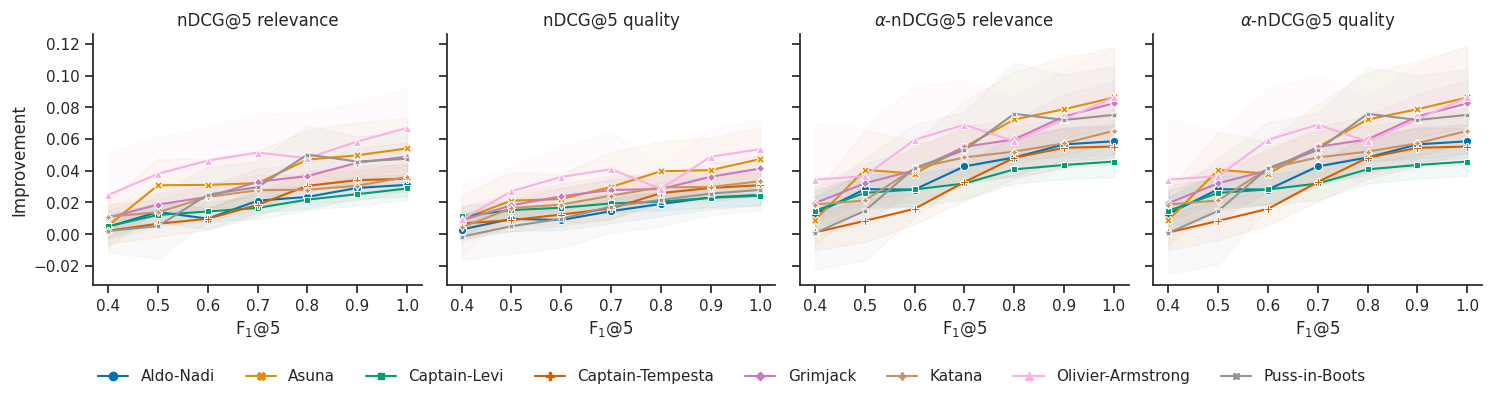

In [58]:
num_comparisons_per_run = 3

In [56]:
set_theme()
set_style("ticks")
plot_significances = FacetGrid(
    data=significances[
        (significances["mean_improvement"] > 0) &
        (significances["p_value"] < (0.05 / num_comparisons_per_run))
        ],
    col="measure",
    ylim=(0, 26),
    sharex=True,
    sharey=False,
    # sharey=True,
    height=3,
    aspect=1.0,
)
plot_significances.map_dataframe(
    histplot,
    element="poly",
    x="target_f1",
    hue="team",
    hue_order=teams,
    palette=color_palette("colorblind")[:len(df["team"].unique())],
    bins=bins,
    multiple="stack",
)
plot_significances.refline(y=len(df["run"].unique()) / 2)
plot_significances.set_ylabels(r"improved runs")
plot_significances.set_xlabels(r"F$_1$-score")
plot_significances.add_legend(
    legend_data=plot_differences._legend_data,
)
plot_significances.savefig("data/plot-reranking-f1-num-significant-runs.pdf", transparent=True)
plot_significances.savefig("data/plot-reranking-f1-num-significant-runs.png")
plot_significances

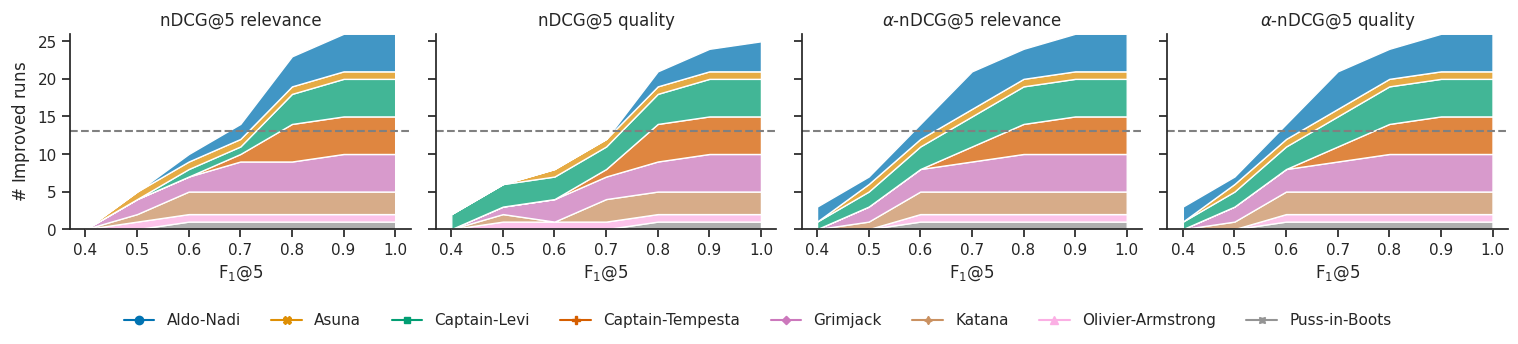